In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
import copy

from nflows.utils import tensor2numpy, create_mid_split_binary_mask
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, 
    InverseTransform,
    BatchNorm,
    PointwiseAffineTransform,
    Tanh,
    ReversePermutation,
    MaskedAffineAutoregressiveTransform as MAF,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform as RQ_NSF_AR,
    PiecewiseRationalQuadraticCouplingTransform as RQ_NSF_C,
    )
from nflows.nn.nets import ResidualNet
from nflows.flows.base import Flow

device = torch.device('cpu')

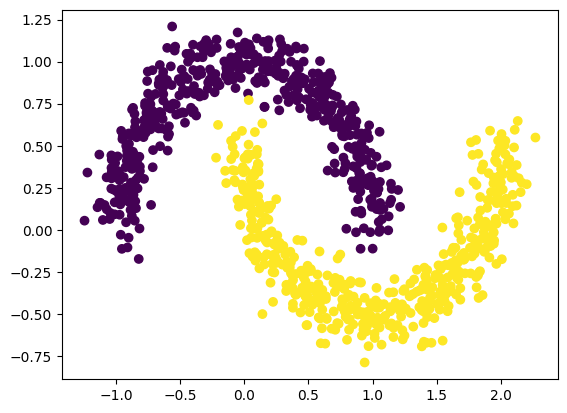

In [3]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

## RQ-NSF-C

In [11]:
num_layers = 5
hidden_features = 100
num_blocks = 2
activation = torch.relu
num_bins = 5
tails = 'linear'
tail_bound = 5.

base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(RQ_NSF_C(
        mask=create_mid_split_binary_mask(2),
        transform_net_create_fn=lambda in_features, out_features: ResidualNet(
            in_features,
            out_features,
            hidden_features=hidden_features,
            context_features=1,
            num_blocks=num_blocks,
            activation=activation,
            dropout_probability=0.,
            use_batch_norm=False,
            ),
        num_bins=num_bins,
        tails=tails,
        tail_bound=tail_bound,
        # apply_unconditional_transform=False,
        # img_shape=None,
        # min_bin_width=splines.rational_quadratic.DEFAULT_MIN_BIN_WIDTH,
        # min_bin_height=splines.rational_quadratic.DEFAULT_MIN_BIN_HEIGHT,
        # min_derivative=splines.rational_quadratic.DEFAULT_MIN_DERIVATIVE,
        ))
    # transforms.append(BatchNorm())
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [18]:
flow.sample(1_000, [0])

RuntimeError: Tensors must have same number of dimensions: got 2 and 1